In [9]:
!pip install docx2txt



In [10]:
import pandas as pd
import numpy as np
import re
from scipy import interp
import os
import string
import docx2txt
from docx import Document
# Visualuzation
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from docx import Document
# NLP Packages
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk
from joblib import dump, load
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier

# Scikit Learn packages
from sklearn.base import clone
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, cross_validate, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Rajap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rajap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rajap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processed file: Business1 - Copy (2).docx
Processed file: Business1 - Copy (3).docx
Processed file: Business1 - Copy (4).docx
Processed file: Business1 - Copy (5).docx
Processed file: Business1 - Copy.docx
Processed file: Business1.docx
Processed file: Business2 - Copy (2).docx
Processed file: Business2 - Copy (3).docx
Processed file: Business2 - Copy (4).docx
Processed file: Business2 - Copy (5).docx
Processed file: Business2 - Copy.docx
Processed file: Business2.docx
Processed file: Business3 - Copy (2).docx
Processed file: Business3 - Copy (3).docx
Processed file: Business3 - Copy (4).docx
Processed file: Business3 - Copy (5).docx
Processed file: Business3 - Copy.docx
Processed file: Business3.docx
Processed file: Science1.docx
Processed file: Science2.docx
Processed file: Science3.docx
Processed file: Sports1 - Copy (2).docx
Processed file: Sports1 - Copy (3).docx
Processed file: Sports1 - Copy (4).docx
Processed file: Sports1 - Copy (5).docx
Processed file: Sports1 - Copy.docx
Pro

C:\Users\Rajap\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rajap\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rajap\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rajap\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWar

Decision Tree Mean Metrics:
test_accuracy              0.222222
test_precision_weighted    0.148148
test_recall_weighted       0.222222
test_f1_weighted           0.177778
dtype: float64
  
Naive Bayes Mean Metrics:
test_accuracy              0.166667
test_precision_weighted    0.083333
test_recall_weighted       0.166667
test_f1_weighted           0.111111
dtype: float64
  
Ridge Classifier Mean Metrics:
test_accuracy              0.277778
test_precision_weighted    0.194444
test_recall_weighted       0.277778
test_f1_weighted           0.222222
dtype: float64
  


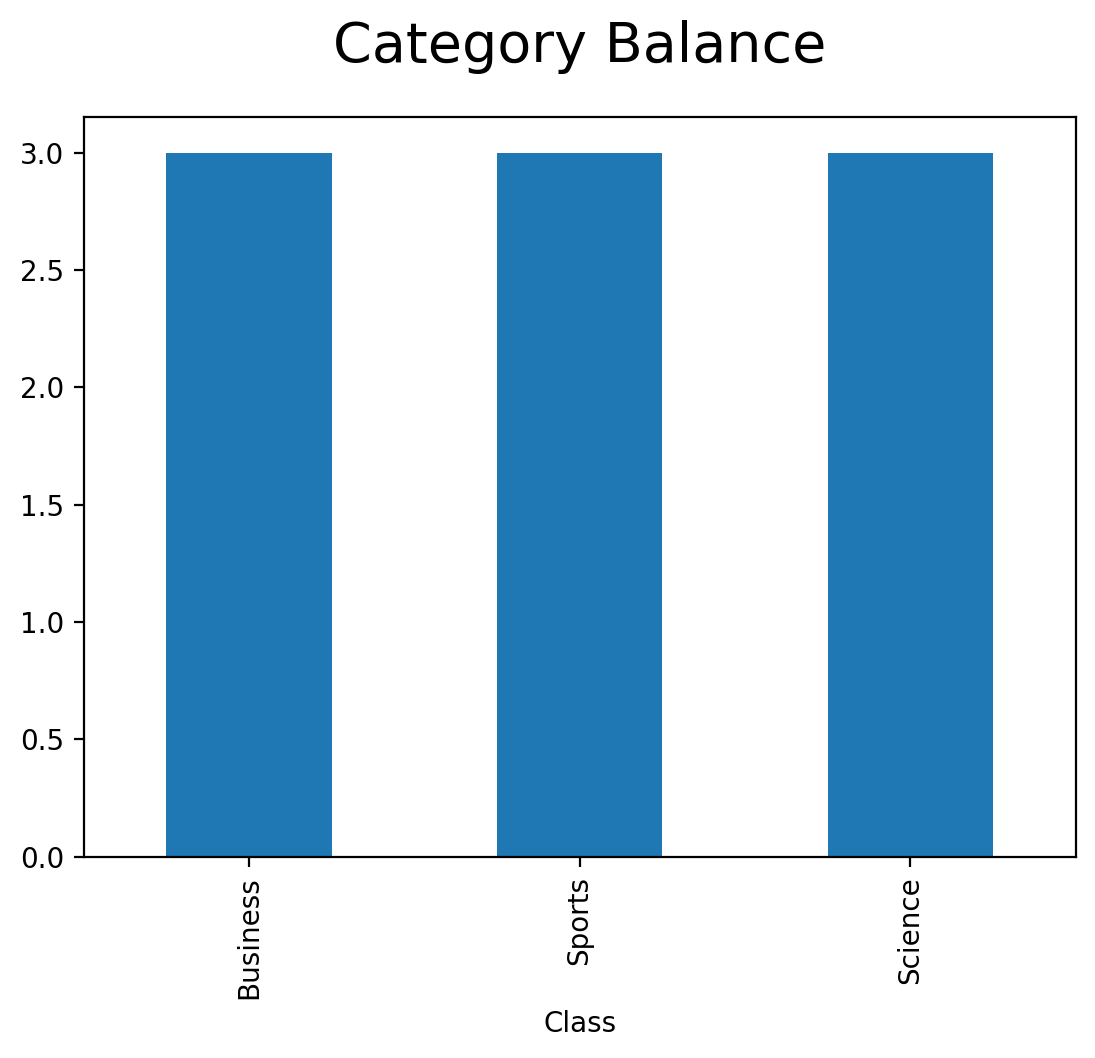

In [11]:
#Reading the files from the directories
def read_files_to_dataframe(directory, category):
    news_df_path = 'news_df.csv'  # Specify the full path to the CSV file
    if not os.path.exists(news_df_path):
        news_df = pd.DataFrame(columns=["Class", "Text"])
    else:
        news_df = pd.read_csv(news_df_path, index_col=0)

    for filename in os.listdir(directory):
        if filename.startswith("~$") or not filename.endswith(".docx"):
            continue

        file_path = os.path.join(directory, filename)
        try:
            with open(file_path, "rb") as fileObject:
                document = Document(fileObject)
                data = " ".join([para.text for para in document.paragraphs])
        except Exception as e:
            print(f"Error while reading {file_path}: {e}")
            continue

        if data not in news_df['Text'].values:
            news_df = pd.concat([news_df, pd.DataFrame({"Class": [category], "Text": [data]})], ignore_index=True)

        print(f"Processed file: {filename}")

    news_df.to_csv(news_df_path, escapechar='\\')
    
# Define directories for each category
business_directory = r'C:\Users\Rajap\Business'
science_directory = r'C:\Users\Rajap\Science'
sports_directory= r'C:\Users\Rajap\Sports'

# Define categories
categories = ['business', 'science', 'sports']

# Read files from each directory and add them to the DataFrame
read_files_to_dataframe(business_directory, categories[0])
read_files_to_dataframe(science_directory, categories[1])
read_files_to_dataframe(sports_directory, categories[2])

# Read the CSV file back into a DataFrame
news_df_path = 'news_df.csv'  # Specify the full path to the CSV file
news_df = pd.read_csv(news_df_path, index_col=0)

# Print the DataFrame
print(news_df)
print(news_df.shape)
news_df.head()

news_df['Class'].value_counts().plot(kind='bar')
plt.title('Number of News articles per Category', size=20, pad=20);

# Check for missing values
news_df.isna().sum()

#Data Preprocessing
def preprocess(df):
    # Remove special characters
    df['Text2'] = df['Text'].replace('\n',' ')
    df['Text2'] = df['Text2'].replace('\r',' ')
    
    # Remove punctuation signs and lowercase all
    df['Text2'] = df['Text2'].str.lower()
    df['Text2'] = df['Text2'].str.translate(str.maketrans('', '', string.punctuation))
    
    
    # Remove stop words
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN,"R": wordnet.ADV, "V": wordnet.VERB,"J": wordnet.ADJ}        
        return hash_tag.get(tag, wordnet.NOUN)

    
    def lematize(text):
        tokens = nltk.word_tokenize(text)
        ax = ""
        for each in tokens:
            if each not in stop_words:
                ax += lemmatizer.lemmatize(each, fwpt(each)) + " "
        return ax
    
    df['Text2'] = df['Text2'].apply(lematize)
    
preprocess(news_df)
print(news_df)

print(news_df.iloc[1]['Text'])
print("\n After Preprocessing")
print(news_df.iloc[1]['Text2'])

def preprocess_text(text):
    # Remove special characters
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')
    
    # Remove punctuation signs and lowercase all
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words and lemmatize
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    
    def fwpt(each):
        tag = pos_tag([each])[0][1][0].upper()
        hash_tag = {"N": wordnet.NOUN, "R": wordnet.ADV, "V": wordnet.VERB, "J": wordnet.ADJ}
        return hash_tag.get(tag, wordnet.NOUN)

    tokens = nltk.word_tokenize(text)
    text = " ".join(lemmatizer.lemmatize(each, fwpt(each)) for each in tokens if each not in stop_words)
    return text

#Splitting the training and testing set
X_train, X_test, y_train, y_test = train_test_split(news_df['Text2'], 
                                                    news_df['Class'], 
                                                    test_size=0.2, 
                                                    random_state=9)
print(y_train)
print(y_test)

y_train.value_counts().plot(kind='bar')
plt.title('Category Balance', size=20, pad=20);

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


#TfidfVectorizer Configuration
vector = TfidfVectorizer(stop_words='english', 
                         ngram_range = (1,2),
                         min_df = 3,
                         max_df = 1.,
                         max_features = 10000)

#Cross validation

def fit_model(model, model_name):
    line = Pipeline([('vectorize', vector), (model_name, model)])
    
    output = cross_validate(line, 
                            X_train, 
                            y_train, 
                            cv = KFold(shuffle = True, 
                                       n_splits = 3,  
                                       random_state = 9),
                            scoring = ('accuracy', 'f1_weighted','precision_weighted','recall_weighted'),           
                            return_train_score=True)
    
    return output

dectree = fit_model(DecisionTreeClassifier(), 'DTree')
ridge = fit_model(RidgeClassifier(), 'Ridge')
bayes = fit_model(MultinomialNB(), 'NB')

dt = pd.DataFrame.from_dict(dectree)
rc = pd.DataFrame.from_dict(ridge)
bc = pd.DataFrame.from_dict(bayes)

l1 = [bc, rc, dt]
l2 =["NB", "Ridge", "DT"]

for each, tag in zip(l1, l2):
    each['model'] = [tag, tag, tag]

joined_output = pd.concat([bc,rc,dt])

relevant_measures = list(['test_accuracy','test_precision_weighted', 'test_recall_weighted', 'test_f1_weighted'])

dec_tree_metrics = joined_output.loc[joined_output.model == 'DT'][relevant_measures]
nb_metrics = joined_output.loc[joined_output.model == 'NB'][relevant_measures]
r_metrics = joined_output.loc[joined_output.model == 'Ridge'][relevant_measures]

metrics_ = [dec_tree_metrics, nb_metrics, r_metrics]
names_ = ['Decision Tree', 'Naive Bayes', 'Ridge Classifier']

for scores, namess in zip(metrics_, names_):
    print(f'{namess} Mean Metrics:')
    print(scores.mean())
    print('  ')
    
# Join training and test datasets
X = pd.concat([X_train, 
               X_test])
y = pd.concat([y_train, 
               y_test])

#Create and Fit a Text Classification Model
def create_and_fit(clf, x, y):
    best_clf = clf
    pipeline = Pipeline([('vectorize', vector), ('model', best_clf)])
    return pipeline.fit(x, y)
# Create model
CLASSIFIER = create_and_fit(MultinomialNB(), X, y)

In [12]:
# Function to get user input and make prediction
def predict_user_input(classifier):
    user_input = input("Enter a news article text: ")
    preprocessed_input = preprocess_text(user_input)

    # Use the classifier to make a prediction
    predicted_class = classifier.predict([preprocessed_input])[0]
    
    print(f"Predicted class: {predicted_class}")

# Now, let's call the predict_user_input() function to get input from the user and make a prediction
predict_user_input(CLASSIFIER)

Enter a news article text: climate change
Predicted class: Science


In [15]:
!pip install tk

In [13]:
import tkinter as tk
from tkinter import scrolledtext
from tkinter import END

# Function to make a prediction
def predict():
    user_input = user_input_text.get(1.0, END).strip()
    if not user_input:
        result_text.config(state=tk.NORMAL)
        result_text.delete(1.0, END)
        result_text.insert(tk.INSERT, "Please enter a news article text.")
        result_text.config(state=tk.DISABLED)
        return

    preprocessed_input = preprocess_text(user_input)
    predicted_class = CLASSIFIER.predict([preprocessed_input])[0]

    result_text.config(state=tk.NORMAL)
    result_text.delete(1.0, END)
    result_text.insert(tk.INSERT, f"Predicted class: {predicted_class}")
    result_text.config(state=tk.DISABLED)

# Create the Tkinter application window
root = tk.Tk()
root.title("Text Classifier GUI")

# Create a label and input text box for the user input
user_input_label = tk.Label(root, text="Enter a news article text:")
user_input_label.pack()
user_input_text = scrolledtext.ScrolledText(root, width=40, height=5, wrap=tk.WORD)
user_input_text.pack()

# Create a button to trigger prediction
predict_button = tk.Button(root, text="Predict", command=predict)
predict_button.pack()

# Create a text widget to display the prediction result
result_text = scrolledtext.ScrolledText(root, width=40, height=3, wrap=tk.WORD, state=tk.DISABLED)
result_text.pack()

# Start the Tkinter event loop
root.mainloop()
